In [ ]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import imgaug.augmenters as iaa
import imgaug as ia
from tensorflow.keras import *
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read img and mask
img_paths = glob('/content/drive/MyDrive/Project/Vessel_segmentation/datasets/train/*.tif')
img_path = np.random.choice(img_paths, size=1)[0]
mask_path = img_path.replace('_training.tif', '_manual1.gif')

print('img path: ', img_path)
print('mask path:',  mask_path)

img = cv2.imread(img_path)[:, :, ::-1]
mask = Image.open(mask_path)
mask = np.array(mask)

img path:  /content/drive/MyDrive/Project/Vessel_segmentation/datasets/train/40_training.tif
mask path: /content/drive/MyDrive/Project/Vessel_segmentation/datasets/train/40_manual1.gif


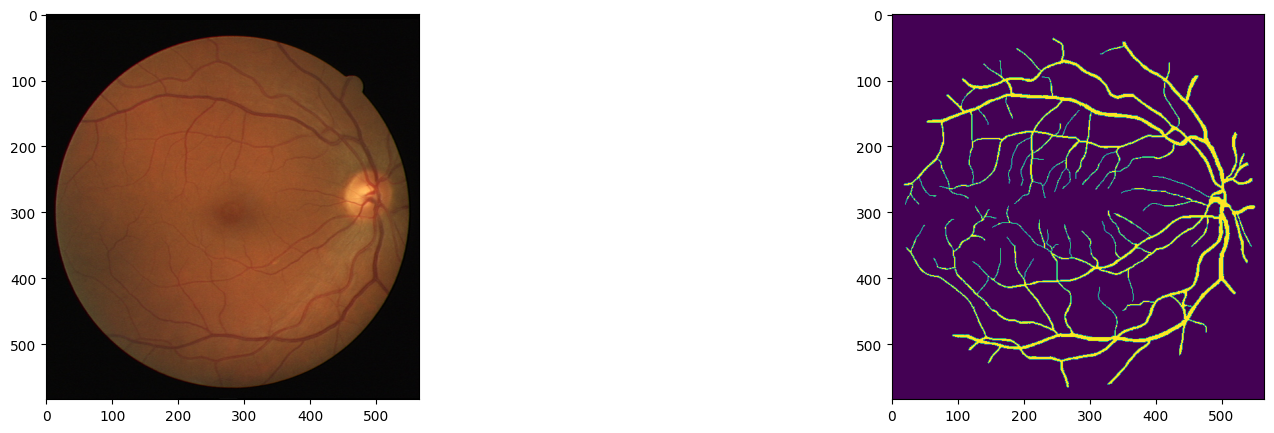

In [ ]:
# show image
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

In [ ]:
img.shape, mask.shape

((584, 565, 3), (584, 565))

In [ ]:
IMG_SIZE = 512 # 16x 32x
BS = 4

In [ ]:
class DataGenerator(utils.Sequence):
    """
    mode: "train" "val", "test"
    """
    def __init__(self, img_paths, batch_size, img_size, shuffle=True, mode='train', aug=False):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.img_size = img_size
        self.mode = mode
        self.img_paths = img_paths
        self.mask_paths = [p.replace('_training.tif', '_manual1.gif') for p in self.img_paths]
        self.aug = aug
        self.indexes = np.arange(len(self.mask_paths))
        # Augmentation
        self.seq = iaa.Sequential([
            iaa.Fliplr(0.5), # 50% horizontal flip
            iaa.Flipud(0.5),
            iaa.Sharpen(alpha=0.5),
            iaa.Affine(
                rotate=(-45, 45),
                shear=(-16, 16),
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}
            ),
        ])
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.mask_paths) / self.batch_size)) # batches per epoch

    def __getitem__(self, index):
        # Generate indexes of the batch
        idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        batch_img_paths = [self.img_paths[i] for i in idxs]
        batch_mask_paths = [self.mask_paths[i] for i in idxs]

        # Generate data
        X, y = self.__data_generation(batch_img_paths, batch_mask_paths)
        if self.mode != 'test':
            return X, y
        else:
            return X

    def on_epoch_end(self):
        # Updates indexes after each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, img_paths, mask_paths):
        # Generates data containing batch_size samples
        x = np.empty((len(img_paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty((len(img_paths), self.img_size, self.img_size, 1), dtype=np.float32)

        for i, (img_path, mask_path) in enumerate(zip(img_paths, mask_paths)):
            img = cv2.imread(img_path)[:, :,::-1]
            img = self.preprocess(img)
            x[i] = img
            if self.mode != 'test':
                mask = np.array(Image.open(mask_path)) # (H, W)
                mask = self.preprocess(mask)
                y[i] = np.expand_dims(mask, axis=-1) # (H, W) -> (H, W, 1)
        if self.aug:
            x, y = self.seq(images=x, heatmaps=y)
        return x, y

    def preprocess(self, img):
        data = cv2.resize(img, (self.img_size, self.img_size))
        data = data / 255. # normalize to 0~1
        return data

In [ ]:
all_paths = glob('/content/drive/MyDrive/Project/Vessel_segmentation/datasets/train/*.tif')
test_paths = sorted(glob('/content/drive/MyDrive/Project/Vessel_segmentation/datasets/test/*.tif'))
train_paths, val_paths = train_test_split(all_paths, test_size=0.2)

train_gen = DataGenerator(train_paths, BS, IMG_SIZE, shuffle=True, mode='train', aug=True)
val_gen = DataGenerator(val_paths, BS, IMG_SIZE, shuffle=False, mode='val')
test_gen = DataGenerator(test_paths, BS, IMG_SIZE, shuffle=False, mode='test')

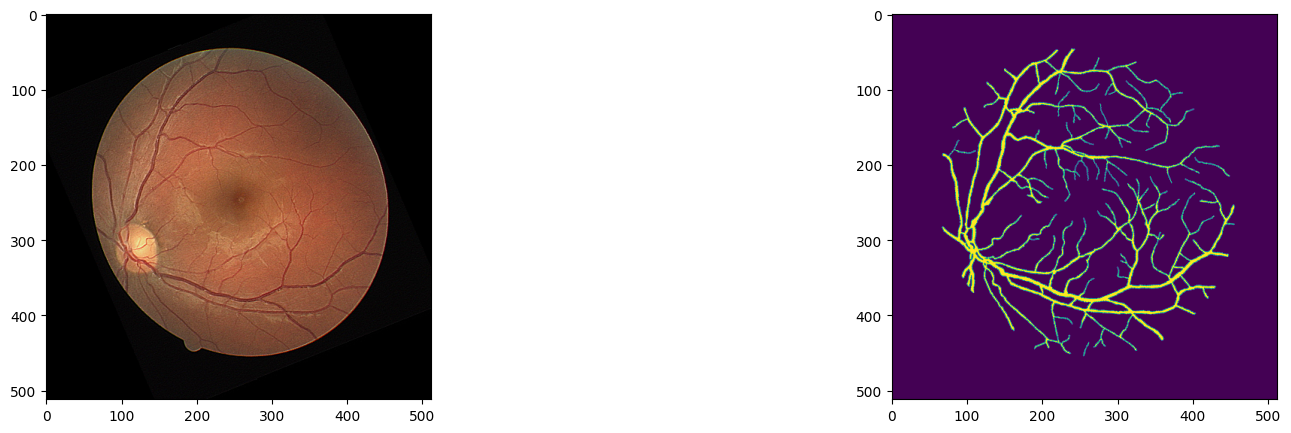

In [ ]:
# Check output

batch_x, batch_y = train_gen[0]

batch_i = np.random.choice(len(batch_x))

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.imshow(batch_x[batch_i], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(batch_y[batch_i, :, :, 0])
plt.show()

In [ ]:
# UNet

# Functional API
def conv_bn(x, filters):
    x = layers.Conv2D(filters=filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

# Subclass
class ConvBN(layers.Layer):
    def __init__(self, filters):
        super().__init__()
        # Method 1
        self.conv = layers.Conv2D(filters=filters, kernel_size=3, padding='same')
        self.bn = layers.BatchNormalization()
        self.act = layers.ReLU()
        # Method 2
        self.seq = models.Sequential([
            layers.Conv2D(filters=filters, kernel_size=3, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU()
        ])
    def call(self, x):
        # Method 1
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x
        # Method 2
        return self.seq(x)

# Encoder
input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = conv_bn(input_layer, 8)
# x = ConvBN(8)(x)
c1 = conv_bn(x, 8)
x = layers.MaxPool2D()(c1)
x = conv_bn(x, 16)
c2 = conv_bn(x, 16)
x = layers.MaxPool2D()(c2)
x = conv_bn(x, 32)
c3 = conv_bn(x, 32)
x = layers.MaxPool2D()(c3)
x = conv_bn(x, 64)
c4 = conv_bn(x, 64)


# Decoder
x = layers.concatenate([layers.UpSampling2D(size=(2,2))(c4),
                        c3], axis=-1)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = layers.concatenate([layers.UpSampling2D(size=(2,2))(x),
                        c2], axis=-1)
x = conv_bn(x, 64)
x = conv_bn(x, 64)
x = layers.concatenate([layers.UpSampling2D(size=(2,2))(x),
                        c1], axis=-1)
x = conv_bn(x, 128)
x = conv_bn(x, 128)

output_layer = layers.Conv2D(filters=1, kernel_size=1, activation='sigmoid')(x)

model = models.Model(input_layer, output_layer)

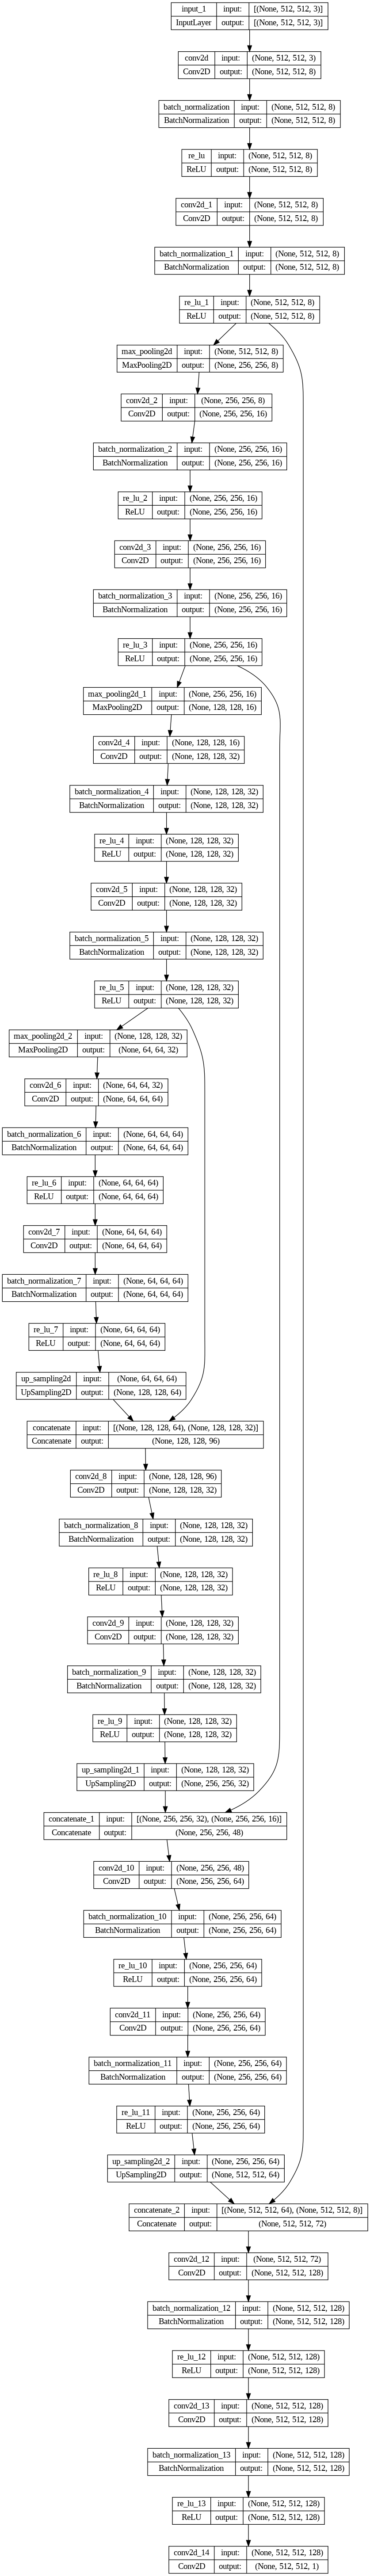

In [ ]:
utils.plot_model(model, show_shapes=True)

In [ ]:
# Customize Dice coefficient
# 0~1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon()) # 1e-6, 1e-7

# dice loss (1.0 ~ 0.0)
# 1-dice_coef

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [ ]:
model.compile(optimizer=optimizers.Adam(),
            #   loss='binary_crossentropy', # dice_loss
              loss=dice_loss, # dice_loss
              metrics=[dice_coef])

In [ ]:
weight_saver = callbacks.ModelCheckpoint('seg.h5',
                                         save_best_only=True)
earlystop = callbacks.EarlyStopping(monitor='val_loss',
                                    patience=100)

In [ ]:
logs = model.fit(train_gen,
                 validation_data = val_gen,
                 epochs=1000,
                 callbacks = [weight_saver, earlystop])

Epoch 1/1000
4/4 [==============================] - 44s 748ms/step - loss: 0.7821 - dice_coef: 0.2179 - val_loss: 0.8330 - val_dice_coef: 0.1670
Epoch 2/1000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 2s 520ms/step - loss: 0.7152 - dice_coef: 0.2848 - val_loss: 0.8423 - val_dice_coef: 0.1577
Epoch 3/1000
4/4 [==============================] - 2s 515ms/step - loss: 0.6435 - dice_coef: 0.3565 - val_loss: 0.8495 - val_dice_coef: 0.1505
Epoch 4/1000
4/4 [==============================] - 2s 518ms/step - loss: 0.5888 - dice_coef: 0.4112 - val_loss: 0.8553 - val_dice_coef: 0.1447
Epoch 5/1000
4/4 [==============================] - 2s 542ms/step - loss: 0.5407 - dice_coef: 0.4593 - val_loss: 0.8628 - val_dice_coef: 0.1372
Epoch 6/1000
4/4 [==============================] - 2s 552ms/step - loss: 0.4803 - dice_coef: 0.5197 - val_loss: 0.8665 - val_dice_coef: 0.1335
Epoch 7/1000
4/4 [==============================] - 2s 512ms/step - loss: 0.4537 - dice_coef: 0.5463 - val_loss: 0.8693 - val_dice_coef: 0.1307
Epoch 8/1000
4/4 [==============================] - 2s 540ms/step - loss: 0.4121 - dice_coef: 0.5879 - val_loss: 0.8751 - val_dice_coef: 0.1249
Epoch

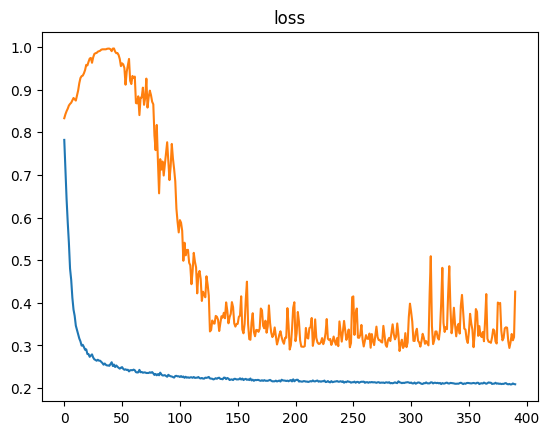

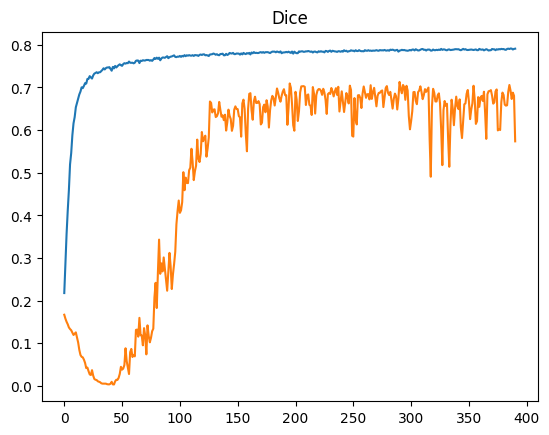

In [ ]:
history = logs.history
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('loss')
plt.show()
plt.plot(history['dice_coef'])
plt.plot(history['val_dice_coef'])
plt.title('Dice')
plt.show()